In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
# Cause plots to be displayed in the notebook:
%matplotlib inline
from energy_functions import twoD_Gaussian,coupled_oscillator_energy_force
from energy_functions import  doubleWellPot as dw
from optimize_functions import local_minimization,perturb_coordinates,acceptance_probability,basin_hopping

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from parallel_temper_EVBH import parallel_temper as ptev

In [9]:
# create local minima

np.random.seed(42)

nlocalminima=100
amps=np.zeros((nlocalminima))
offsets=np.zeros((nlocalminima))
xy0=np.zeros((nlocalminima,2))
sigma_xy=np.zeros((nlocalminima,2))
thetas=np.zeros((nlocalminima))


for i in range(nlocalminima):
    amps[i]=-10*np.abs(np.random.randn())
    offsets[i]=0 #-1*np.abs(np.random.randn())
    xy0[i,:]=4*np.random.rand(2)-2
    sigma_xy[i,:]=0.1*np.random.rand(2)
    thetas[i]=np.pi*np.random.randn()

In [10]:
# redefine energy function so it takes in x,y as a vector 
def pes(x1,nlocalminima=nlocalminima,amps=amps,offsets=offsets,xy0=xy0,sigma_xy=sigma_xy,thetas=thetas,**kwargs):
    x,y=x1
    ene1,_,_=coupled_oscillator_energy_force(x,y,d0=0.3,a=1.0,k=2.2,lamb=1.978)
    nx=0
    for i in range(nlocalminima):
        xo,yo=xy0[i,:]
        sigma_x,sigma_y=sigma_xy[i,:]
        nx=nx+twoD_Gaussian(x, y, amps[i], xo, yo, sigma_x, sigma_y, thetas[i], offsets[i])
    return ene1+nx

In [11]:
# redefine energy function so it takes in x,y as a vector 
# also calculate the bias term
def pes_EV(x1,s,kspr,nlocalminima=nlocalminima,amps=amps,offsets=offsets,xy0=xy0,sigma_xy=sigma_xy,thetas=thetas,**kwargs):
    x,y=x1
    ene1,_,_=coupled_oscillator_energy_force(x,y,d0=0.3,a=1.0,k=2.2,lamb=1.978)
    nx=0
    for i in range(nlocalminima):
        xo,yo=xy0[i,:]
        sigma_x,sigma_y=sigma_xy[i,:]
        nx=nx+twoD_Gaussian(x, y, amps[i], xo, yo, sigma_x, sigma_y, thetas[i], offsets[i])
    bias=kspr*(x-s)**2
    return ene1+nx+bias

(2, 100, 100)
<class 'numpy.ndarray'>


<a list of 115 text.Text objects>

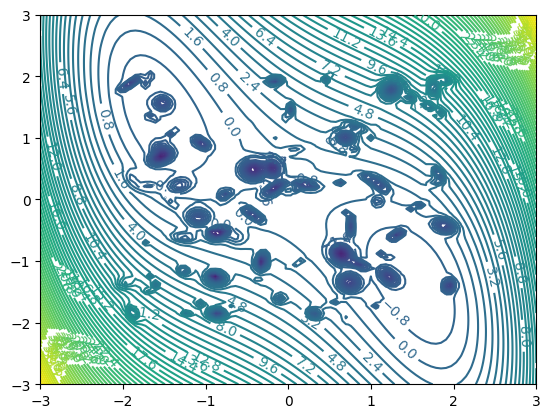

In [12]:
xmin,xmax=-3,3
x_points = np.linspace(xmin,xmax,100)
y_points = np.linspace(xmin,xmax,100)
X, Y = np.meshgrid(x_points, y_points)
XY=np.vstack([[X],[Y]])
print(np.shape(XY))
print(type(XY[:,0,0]))
Z=pes(XY)
CS = plt.contour(X, Y, Z, levels=100)
plt.clabel(CS, inline=1, fontsize=10)

In [13]:
# X0=4*np.random.rand(2)-2
# X0=np.array([0.2,-1.2])
# Set the initial state of all replicas
nrep = 2                          # Number of replicas
dim = 2                            # Number of dimensions 
X0=np.zeros((dim,nrep))            # rows are the x,y coords in each column replica - capatibility for the way we setup pes
for rep in range(nrep):
    X0[:,rep] = 4*np.random.rand(dim)-2.0           # initial x position of each replice

X0=np.array([[1.5,1.5],[1.0,1.0]] )
# X0=np.array([[1.5,1.0],[1.5,1.0]]) # initial positions on the surface for two baths
print(X0)
print(X0[:,0])
print(pes(X0[:,1]))
print(pes(X0))
s=np.zeros((nrep))
s[:]=X0.copy()[0,:] # this is the starting EV which is the top row i.e. x-component
X0,s

[[1.5 1.5]
 [1.  1. ]]
[1.5 1. ]
4.53575
[4.53575 4.53575]


(array([[1.5, 1.5],
        [1. , 1. ]]),
 array([1.5, 1.5]))

In [9]:
from optimize_functions import local_minimization_EV

# no exchange 
#### setting alpha=1 and update shifts every 2 steps
#### how does the spring constant and temperature affect the equilibration ?
#### this part is way tricky. Get rough parameters that work and do not update 
#### try doing a grid search 

In [110]:
betas=np.linspace(0.1,0,2)  # large beta is cold 
gap=0.1
Temp = 1/(betas+gap)
Temp

array([ 5., 10.])

In [156]:
# Set simulation parameters


nsteps = 50      # Number of MC sweeps 10000
bs=1             # batchsize
refreq = 0.0 # 0.001       # 0.5 Fraction of the time to attempt replica exchange
Temp = np.array([5.0,10])     # Temperature at each replica])     # Temperature at each replica
maxdr = np.array([0.07696244,1.11386114])     # Maximal displacement in each MC step, for each replica
kspr = np.array([1.0, 0.5])     # spring for each rep

u0=  pes(X0)
u = pes_EV(X0,s,kspr) # initial potential energy of the particle
print(u0)
print(u)



[4.53575 4.53575]
[4.53575 4.53575]


In [61]:
print(X0)
x_new = X0.copy()
for rep in range(nrep):
    x_new[:,rep] = local_minimization_EV(X0[:,rep],s[rep],kspr[rep],pes_EV)
print(x_new)
u = pes_EV(X0,s,kspr) # initial potential energy of the particle
print(u)

[[1.5 1.5]
 [1.  1. ]]
[[ 1.50015055  1.50015055]
 [-1.34907387 -1.34907387]]
[4.53575 4.53575]


In [159]:
xTraj,sTraj = ptev(pes_EV,X0,nrep,nsteps,dim,refreq,Temp,maxdr,bs,kspr)
# has shape  xTraj[dim,rep,m,step] 

step: 0 Temp: 5.000 acc1: 1.000 acc2: 0.000 rej: 0.000 maxdr: 0.009 dev: 0.002  kspr: 1.000 
step: 0 Temp: 10.000 acc1: 0.000 acc2: 0.000 rej: 1.000 maxdr: 0.617 dev: -0.154  kspr: 0.500 
step: 10 Temp: 5.000 acc1: 0.455 acc2: 0.364 rej: 0.182 maxdr: 0.009 dev: 0.001  kspr: 1.000 
step: 10 Temp: 10.000 acc1: 0.455 acc2: 0.455 rej: 0.091 maxdr: 0.617 dev: 0.126  kspr: 0.500 
step: 20 Temp: 5.000 acc1: 0.238 acc2: 0.333 rej: 0.429 maxdr: 0.009 dev: 0.000  kspr: 1.000 
step: 20 Temp: 10.000 acc1: 0.476 acc2: 0.381 rej: 0.143 maxdr: 0.617 dev: 0.110  kspr: 0.500 
step: 30 Temp: 5.000 acc1: 0.161 acc2: 0.290 rej: 0.548 maxdr: 0.009 dev: -0.000  kspr: 1.000 
step: 30 Temp: 10.000 acc1: 0.452 acc2: 0.419 rej: 0.129 maxdr: 0.617 dev: 0.115  kspr: 0.500 
step: 40 Temp: 5.000 acc1: 0.122 acc2: 0.220 rej: 0.659 maxdr: 0.009 dev: -0.001  kspr: 1.000 
step: 40 Temp: 10.000 acc1: 0.390 acc2: 0.390 rej: 0.220 maxdr: 0.617 dev: 0.087  kspr: 0.500 
step: 50 Temp: 5.000 acc1: 0.098 acc2: 0.176 rej: 0.72

In [27]:
np.shape(xTraj)
rep=0
print(X0[:,rep])
print(xTraj[:,rep,0])
print(xTraj[:,rep,-1])


[-1.2537319  -0.85961933]
[[-0.42312557  0.91391444 -0.16286689 -1.87770026  0.02074538  0.69198968
  -1.53944762 -1.88312314 -1.23788587 -2.96032334 -1.05060107 -2.2393935
  -1.1086386  -1.83030777 -1.04571361 -1.51843935 -1.29462697 -1.41506115
  -1.70898767 -1.53617197 -1.70891564 -1.53648026 -1.53645385 -1.63641316
  -1.53426841 -1.52012266 -1.69949192 -1.52826563 -1.52760602 -1.53686407
  -1.52999355 -1.529769   -1.52549872 -1.53716858 -1.53674505 -1.52597715
  -1.53681101 -1.53680129 -1.53688958 -1.52690989 -1.53691058 -1.52709501
  -1.52714866 -1.52675449 -1.5269798  -1.52702495 -1.52704278 -1.52691729
  -1.63712189 -1.52692802]
 [ 0.48777268 -0.87105759  0.18536599 -1.84578359 -0.02407272  1.00727281
   0.69882597 -1.84078936 -0.61653203  2.66184907  0.91345952  2.01488192
  -0.28780913  1.65184684  0.91101931  1.56161215  1.14215465 -0.04589568
   1.28864256  0.70018012  1.28588008  0.70005455  0.70006218  1.34029726
   1.56280261  1.56177787  1.9508218   1.56236622  1.5623117

In [313]:
np.min(xTraj)

-2.334613726799267

(2, 100, 100)
<class 'numpy.ndarray'>


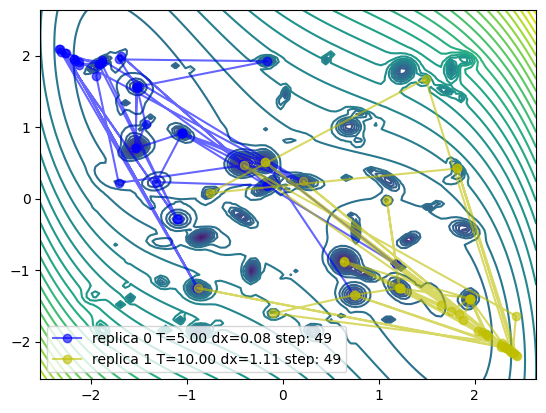

In [153]:
xmin,xmax=np.min(xTraj[:,:,:]),np.max(xTraj[:,:,:])
margin=0.2
x_points = np.linspace(xmin-margin,xmax+margin,100)
y_points = np.linspace(xmin-margin,xmax+margin,100)
X, Y = np.meshgrid(x_points, y_points)
XY=np.vstack([[X],[Y]])
print(np.shape(XY))
print(type(XY[:,0,0]))
Z=pes(XY)
CS = plt.contour(X, Y, Z, levels=50)
CS = plt.margins(0.05) # this is not really having much effect 
# rgb=np.random.uniform(size=(nrep,3))
rgb = 'bycm'
for rep in range(nrep):
# rep=0
 for m in range(bs):
# for step in range(nsteps):
#    CS = plt.plot([X0[0,rep],xTraj[0,rep,0]], [X0[1,rep] , xTraj[1,rep,0]],'o',markersize=9,markeredgecolor='k',linestyle='-',alpha=0.6,color=rgb[rep]*0.9)
#    CS = plt.plot(xTraj[0,rep,:,step],xTraj[1,rep,:,step],linestyle='-',marker='o',color=rgb[rep],markersize=6,alpha=0.6,label='replica %i T=%.2f dx=%.2f step: %i'%(rep,Temp[rep],maxdr[rep],step))
    CS = plt.plot(xTraj[0,rep,m,:],xTraj[1,rep,m,:],linestyle='-',marker='o',color=rgb[rep],markersize=6,alpha=0.6,label='replica %i T=%.2f dx=%.2f step: %i'%(rep,Temp[rep],maxdr[rep],step))
    # CS = plt.plot(xTraj[0,rep,0], xTraj[1,rep,0],'^',markersize=9,linestyle='none',color='green')
#  CS = plt.plot(xTraj[0,rep,-1], xTraj[1,rep,-1],'>',markersize=9,linestyle='-',color='red')
CS = plt.legend()


In [316]:
from parallel_temper_BH import parallel_temper as ptbh

# Another example with no exchange 

In [361]:
np.random.seed(42)
# Set the initial state of all replicas
nrep = 2                           # Number of replicas
dim = 2                            # Number of dimensions 
X0=np.zeros((dim,nrep))            # rows are the x,y coords in each column replica - capatibility for the way we setup pes
# for rep in range(nrep):
#     X0[:,rep] = 4*np.random.rand(dim)-2.0              # initial x position of each replice

X0=np.array([[1.5,1.5],[1.0,1.0]] )
# Set simulation parameters

nsteps = 50      # Number of MC sweeps 10000
refreq = 0.0 # 0.001       # 0.5 Fraction of the time to attempt replica exchange
Temp = np.array([50.0,100.0])     # Temperature at each replica
maxdr = np.array([0.1,0.5])     # Maximal displacement in each MC step, for each replica

u = pes(X0) # initial potential energy of the particle
u


array([4.53575, 4.53575])

In [362]:
xTraj = ptbh(pes,X0,nrep,nsteps,dim,refreq,Temp,maxdr)

(2, 100, 100)
<class 'numpy.ndarray'>


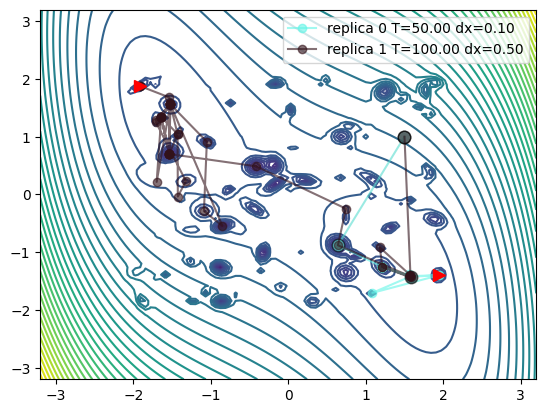

In [364]:
# xmin,xmax=np.min(xTraj[:,:,:]),np.max(xTraj[:,:,:])
xmin,xmax=-3,3
margin=0.2
x_points = np.linspace(xmin-margin,xmax+margin,100)
y_points = np.linspace(xmin-margin,xmax+margin,100)
X, Y = np.meshgrid(x_points, y_points)
XY=np.vstack([[X],[Y]])
print(np.shape(XY))
print(type(XY[:,0,0]))
Z=pes(XY)
CS = plt.contour(X, Y, Z, levels=50)
CS = plt.margins(0.05) # this is not really having much effect 
rgb=np.random.uniform(size=(nrep,3))
for rep in range(nrep):
## rep=1
 CS = plt.plot([X0[0,rep],xTraj[0,rep,0]], [X0[1,rep] , xTraj[1,rep,0]],'o',markersize=9,markeredgecolor='k',linestyle='-',alpha=0.6,color=rgb[rep]*0.9)
 CS = plt.plot(xTraj[0,rep,:],xTraj[1,rep,:],linestyle='-',marker='o',color=rgb[rep],markersize=6,alpha=0.6,label='replica %i T=%.2f dx=%.2f'%(rep,Temp[rep],maxdr[rep]))
 # CS = plt.plot(xTraj[0,rep,0], xTraj[1,rep,0],'^',markersize=9,linestyle='none',color='green')
 CS = plt.plot(xTraj[0,rep,-1], xTraj[1,rep,-1],'>',markersize=9,linestyle='-',color='red')
CS = plt.legend()

# An example with  exchange 

In [365]:
np.random.seed(42)
# Set the initial state of all replicas
nrep = 2                           # Number of replicas
dim = 2                            # Number of dimensions 
X0=np.zeros((dim,nrep))            # rows are the x,y coords in each column replica - capatibility for the way we setup pes
# for rep in range(nrep):
#     X0[:,rep] = 4*np.random.rand(dim)-2.0              # initial x position of each replice

X0=np.array([[1.5,1.5],[1.0,1.0]] )
# Set simulation parameters

nsteps = 50      # Number of MC sweeps 10000
refreq = 0.5 # 0.001       # 0.5 Fraction of the time to attempt replica exchange
Temp = np.array([50.0,100.0])     # Temperature at each replica
maxdr = np.array([0.1,0.5])     # Maximal displacement in each MC step, for each replica

u = pes(X0) # initial potential energy of the particle
u


array([4.53575, 4.53575])

In [366]:
xTraj = ptbh(pes,X0,nrep,nsteps,dim,refreq,Temp,maxdr)

exchange at step 9
exchange at step 13
exchange at step 16
exchange at step 22
exchange at step 30
exchange at step 32
exchange at step 41
exchange at step 42
exchange at step 44
exchange at step 45
exchange at step 48


(2, 100, 100)
<class 'numpy.ndarray'>


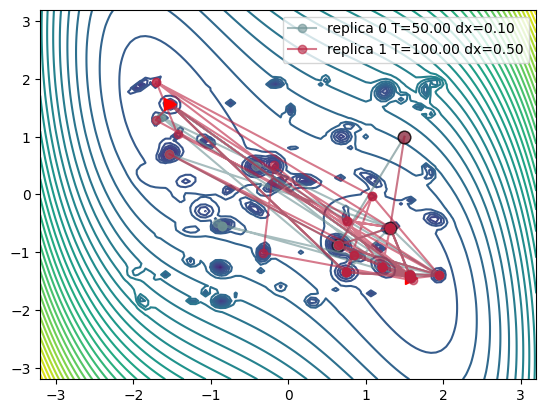

In [367]:
# xmin,xmax=np.min(xTraj[:,:,:]),np.max(xTraj[:,:,:])
xmin,xmax=-3,3
margin=0.2
x_points = np.linspace(xmin-margin,xmax+margin,100)
y_points = np.linspace(xmin-margin,xmax+margin,100)
X, Y = np.meshgrid(x_points, y_points)
XY=np.vstack([[X],[Y]])
print(np.shape(XY))
print(type(XY[:,0,0]))
Z=pes(XY)
CS = plt.contour(X, Y, Z, levels=50)
CS = plt.margins(0.05) # this is not really having much effect 
rgb=np.random.uniform(size=(nrep,3))
for rep in range(nrep):
## rep=1
 CS = plt.plot([X0[0,rep],xTraj[0,rep,0]], [X0[1,rep] , xTraj[1,rep,0]],'o',markersize=9,markeredgecolor='k',linestyle='-',alpha=0.6,color=rgb[rep]*0.9)
 CS = plt.plot(xTraj[0,rep,:],xTraj[1,rep,:],linestyle='-',marker='o',color=rgb[rep],markersize=6,alpha=0.6,label='replica %i T=%.2f dx=%.2f'%(rep,Temp[rep],maxdr[rep]))
 # CS = plt.plot(xTraj[0,rep,0], xTraj[1,rep,0],'^',markersize=9,linestyle='none',color='green')
 CS = plt.plot(xTraj[0,rep,-1], xTraj[1,rep,-1],'>',markersize=9,linestyle='-',color='red')
CS = plt.legend()